## Case 01: Variational Autoencoder (VAE)
* Dataset: CIFAR100
* DL Framework: Tensorflow-Keras
* DL Task: Image reconstruction

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`OBJECTIVE` Achieve a min. validation accuracy of <b>90%</b> within <b>10 epochs</b>.
<br>`WARNING` Do <b>NOT</b> change any codes in the <i>config.ipynb</i> file.

### Import libraries

In [1]:
from tensorflow import keras
import tensorflow as tf

import numpy as np
from ipynb.fs.full.config import init, load_cifar_100_data, accuracy, show_reconstructions
import ssl
import math
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### Load the dataset

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
(X_train, _), (X_valid, _), (_, _) = load_cifar_100_data()
print(X_train.shape, X_valid.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


### Configure the hyperparameters

In [3]:
EPOCH = init()["EPOCH"] # DO NOT CHANGE THIS
SEED = init()["SEED"] # DO NOT CHANGE THIS
BATCH_SIZE = 16 #TODO: set hyperparameters (int)
CODINGS_SIZE = 16 #TODO: set parameters for the latent space representation (int)
LEARNING_RATE = 0.001 #TODO: set hyperparameters (int)
IMG_SIZE = (32,32,3) #TODO: define the image size

In [4]:
tf_random = tf.random
np_random = np.random

K = keras.backend
tf_random.set_seed(SEED) # for reproduciable results
np_random.seed(SEED) # for reproduciable results

### Define the Model

In [5]:
tf_shape = tf.shape
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf_shape(log_var)) * K.exp(log_var / 2) + mean 

In [6]:
def encoder(i, c, *args, **kwargs):
    """
    function name:
        encoder() = to compress the image inputs (latent)
    function parameters:
        i = image size
        c = coding size
    """
    inputs = keras.layers.Input(shape=i)
    #TODO: define the layers stack for the encoder part. you may use MLP, LSTM, or CNN.
    # variable 'z' will be the first layer
    # z = keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    # z = keras.layers.Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(z)
    # z = keras.layers.MaxPooling2D()(z)
    # z = keras.layers.Conv2D(256, 3, strides=1, padding='valid')(inputs)
    # z = keras.layers.Conv2D(1, 3, strides=1, padding='same')(z)
    z = keras.layers.Dense(8)(inputs)
    z = keras.layers.Dense(5)(z)
    z = keras.layers.Dense(3)(z)
    z = keras.layers.Flatten()(z)

    codings_mean = keras.layers.Dense(c)(z)
    codings_log_var = keras.layers.Dense(c)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    return keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]), inputs, codings_mean, codings_log_var

In [7]:
def decoder(i, c, *args, **kwargs):
    """
    function name:
        decoder = to reconstruct the image (with the same size) from the compressed version (latent)
    function parameters:
        i = image size
        c = coding size
    """
    decoder_inputs = keras.layers.Input(shape=[c])
    #TODO: define the layers stack for the decoder part. you may use MLP, LSTM, or CNN.
    # variable 'x' will be the first layer
    embedding = keras.layers.Dense(np.prod((32, 32, 3)), activation='relu')(decoder_inputs)
    embedding = keras.layers.Reshape([32, 32, 3])(embedding)
    # x = keras.layers.UpSampling2D()(embedding)
    # x = keras.layers.Conv2D(48, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    # x = keras.layers.Conv2D(48, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    # x = keras.layers.Conv2DTranspose(256,(3,3), padding='valid', strides=1)(embedding)
    # x = keras.layers.Conv2DTranspose(3,(3,3),padding='same', strides=1)(x)
    # x = keras.layers.Conv2DTranspose(18,(3,3),padding='valid', strides=1)(x)
    # x = keras.layers.Conv2DTranspose(3, (3,3))(x)
    x = keras.layers.Dense(8)(embedding)
    x = keras.layers.Dense(5)(x)
    x = keras.layers.Dense(3)(x)
    outputs = keras.layers.Dense(3)(x)
    
    # outputs = keras.layers.Conv2DTranspose(3, 3)(x)
    # outputs = keras.layers.Conv2DTranspose(3, (3,3), padding='same', strides=1)(x)
    return keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [8]:
variational_encoder, inputs, codings_mean, codings_log_var = encoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_encoder.summary() # keep the trainable params below 20,000 is advised

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 32, 32, 8)    32          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32, 32, 5)    45          ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32, 32, 3)    18          ['dense_1[0][0]']                
                                                                                              

In [9]:
variational_decoder = decoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_decoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_5 (Dense)             (None, 3072)              52224     
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 dense_6 (Dense)             (None, 32, 32, 8)         32        
                                                                 
 dense_7 (Dense)             (None, 32, 32, 5)         45        
                                                                 
 dense_8 (Dense)             (None, 32, 32, 3)         18        
                                                                 
 dense_9 (Dense)             (None, 32, 32, 3)         12  

In [10]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / (math.prod(IMG_SIZE)))

### Compile the model

In [11]:
#TODO: define your loss function, optimizer, and metric
import tensorflow as tf

def compute_loss(data, reconstruction, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + codings_log_var - tf.square(codings_mean) - tf.exp(codings_log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss

In [12]:
variational_ae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=compute_loss, metrics=['accuracy'])

### Train the model
* <b>Bechmark:</b> Validation accuracy fell at `91.48%` within 10 epochs.
* If you encounter this `WARNING:tensorflow:AutoGraph ...` in the first epoch, please ignore.

In [13]:
history = variational_ae.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, X_valid))

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - ETA: 0s - loss: 43.5898 - accuracy: 0.5391

I:\Work\Devs\ds-case\venv\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


45000/45000 [==============================] - 24s 536us/sample - loss: 43.5898 - accuracy: 0.5391 - val_loss: 37.5510 - val_accuracy: 0.5869
Epoch 2/10
45000/45000 [==============================] - 24s 536us/sample - loss: 37.0616 - accuracy: 0.5816 - val_loss: 37.2070 - val_accuracy: 0.5531
Epoch 3/10
45000/45000 [==============================] - 25s 547us/sample - loss: 36.7672 - accuracy: 0.5853 - val_loss: 36.8466 - val_accuracy: 0.6097
Epoch 4/10
45000/45000 [==============================] - 24s 528us/sample - loss: 36.6780 - accuracy: 0.5871 - val_loss: 36.7652 - val_accuracy: 0.5909
Epoch 5/10
45000/45000 [==============================] - 24s 544us/sample - loss: 36.5987 - accuracy: 0.5885 - val_loss: 36.6355 - val_accuracy: 0.6076
Epoch 6/10
45000/45000 [==============================] - 25s 563us/sample - loss: 36.5358 - accuracy: 0.5885 - val_loss: 37.1205 - val_accuracy: 0.5835
Epoch 7/10
45000/45000 [==============================] - 25s 549us/sample - loss: 36.4863 - 

### Visualize training and validation results

Example output:

![VAE_acc_loss](img/vae_plot.png)

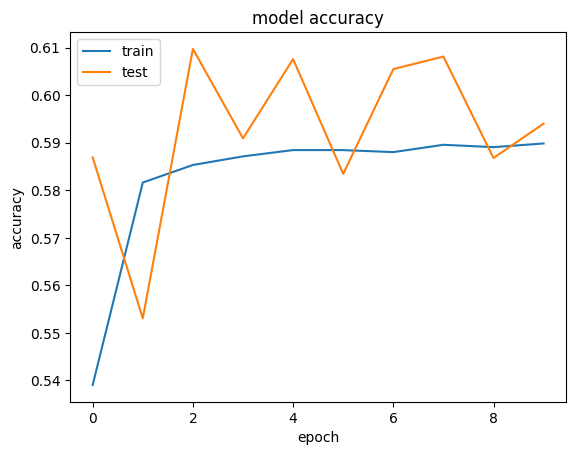

In [14]:
#TODO: plot the loss and accuracy results from both training and validation, as depicted in the image above
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

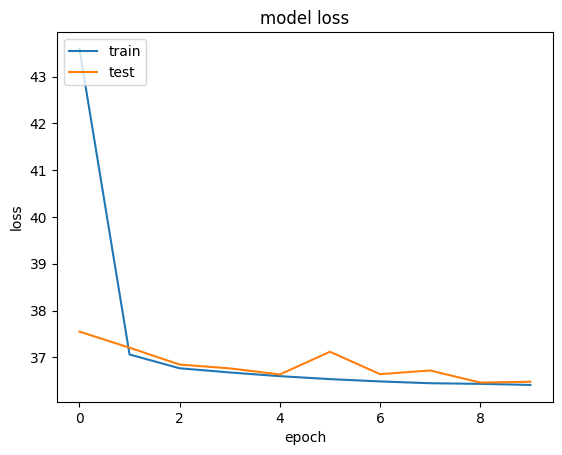

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test the model

I:\Work\Devs\ds-case\venv\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


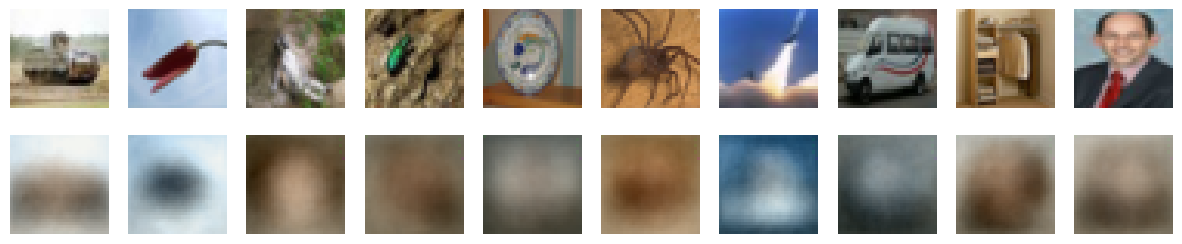

In [16]:
show_reconstructions(variational_ae, X_valid)

### Copyright 2022 PT. Agriaku Digital Indonesia
* You may NOT use this file except there is written permission from AgriAku.
* Any questions can be address to `nicholas.dominic@agriaku.com`.